In [1]:
import os

os.environ['TF_METAL_AMP_ENABLED'] = 'false'

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pywt
import time
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
import biosppy.signals.ecg as ecg
import cv2
import neurokit2 as nk
import os
import shutil

# from sklearn.preprocessing import RobustScaler, StandardScaler

In [3]:
extraction_directory = 'extracted_images/'

In [4]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train['y'].to_numpy()

In [5]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

# PREPOCESSING

In [6]:
from numpy.random import RandomState

prng = RandomState(0)

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    signal = signal.copy()
    # Time Shifting
    if max_shift > 0:
        shift = prng.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        signal *= prng.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)

    # Adding Noise
    if noise_level > 0:
        signal += pd.DataFrame(prng.normal(0, noise_level, size=signal.size + 500)).rolling(window=500).median().to_numpy().squeeze()[500:]

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = prng.uniform(1 - max_freq_change, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        if freq_change > 1:
            signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]
        elif freq_change < 1:
            signal = np.tile(np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal), 2)[:signal.size]
    return signal


In [7]:
initial_signal_ids = dict()
for class_label in range(4):
    initial_signal_ids[class_label] = []
for class_label in range(4):
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:
            initial_signal_ids[class_label].append(i)

In [8]:
multiplier = 1

class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution[name] , class_distribution[name] / y_train_np.size))
print('')

# Parameters for augmentation
max_shift = 400  # Maximum shift for time shifting
scaling_factor_range = 0#0.05  # Scaling factor range for scaling
noise_level = 500  # Noise level for adding noise
max_freq_change = 0.1  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label, repetitions in enumerate([((class_distribution[0] * multiplier ) // (2*v)) for v in class_distribution.values()]):
    for _ in range(repetitions):
        for index in initial_signal_ids[class_label]:
            augmented_signal = augment_signal(X_train_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# Convert augmented data to numpy arrays and add to original dataset
X_train_extended_np = np.array(X_augmented)
y_train_extended_np = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution_extended:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution_extended[name], class_distribution_extended[name] / y_train_extended_np.size))

Original:
0: 3030 = 59.21%
1: 443 = 8.66%
2: 1474 = 28.81%
3: 170 = 3.32%

Extended:
0: 3030 = 32.65%
1: 1772 = 19.09%
2: 2948 = 31.77%
3: 1530 = 16.49%


In [9]:
def process_signal(signal):

    length = signal.size

    signal = signal[~np.isnan(signal)]

    features = ecg.ecg(signal, 300, show=False)

    peaks = correct_rpeaks(features[1], features[2], 300, .15)
    median_peak_val = np.median(features[1][peaks])

    if median_peak_val == 0 or median_peak_val == np.nan:
        raise Exception()
    
    a = np.empty((length-signal.size,))
    a[:] = np.nan
    
    return np.concatenate([(np.array(features[1]) - np.median(features[1])) / median_peak_val, a])


In [10]:
X_train_transformed_np = np.array([process_signal(row) for row in X_train_extended_np])
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train_extended.columns, index=X_train_extended.index)

# IMAGE GENERATION

In [11]:
X_train_transformed_with_index = X_train_transformed.copy()
X_train_transformed_with_index['index'] = X_train_transformed.index

In [12]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended_np)

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_transformed_with_index.to_numpy(), y_train_cat_np, test_size=0.4, random_state=23)

In [13]:
directory = '/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/AML/task2/images'

def reset(directory = directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)

    if not os.path.exists(directory):
        os.makedirs(directory)

    for folder in ['train', 'val']:
        subdirectory = os.path.join(directory, folder)
        os.makedirs(subdirectory)
        for i in range(4):
            subsubdirectory = os.path.join(subdirectory, str(i))
            os.makedirs(subsubdirectory)
    
    subdirectory = os.path.join(directory, 'test/unkown')
    os.makedirs(subdirectory)

In [14]:
IMAGE_SIZE = (128, 128)

In [15]:
matplotlib.use('Agg')

def save_heartbeat_images(index, signal, directory, test=False):
    
    peaks = correct_rpeaks(signal, nk.ecg_peaks(signal, sampling_rate=300)[1]['ECG_R_Peaks'], 300, .15)[0]
    
    beats = ecg.extract_heartbeats(signal, peaks, 300)['templates']

    for i, beat in enumerate(beats):

        fig = plt.figure(frameon=False)
        plt.plot(beat, linewidth=5)
        plt.xticks([]), plt.yticks([])
        for spine in plt.gca().spines.values():
            spine.set_visible(False)

        if test:
            filename = directory + f'/ECG{index}_heartbeat{i}.png'
        else:
            filename = directory + '/' + str(y_train_extended_np[index]) + f'/ECG{index}_heartbeat{i}.png'
        fig.savefig(filename)
        im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        im_gray = cv2.resize(im_gray, IMAGE_SIZE, interpolation = cv2.INTER_LANCZOS4)
        cv2.imwrite(filename, im_gray)
        # cropping(im_gray, filename)
        plt.close('all')  

In [16]:
def process_data(data, directory=directory + '/train', test=False):
    start = time.time()
    counter = 0

    for row in data:

        save_heartbeat_images(int(row[-1]), row[:-1], directory, test)

        counter += 1
        if counter % 10 == 0:
            print('.', end='')
        
        if counter % 1000 == 0:
            print('')

    print('\n' + str(time.time() - start))

In [17]:
reset()

process_data(X_train_partial)

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................................
6004.830610990524


In [18]:
process_data(X_val, directory + '/val')

....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................
4008.269727230072


# OBTAIN TEST DATA

In [19]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_transformed_np = np.array([process_signal(row) for row in X_test_np])
X_test_transformed = pd.DataFrame(data=X_test_transformed_np, columns=X_test.columns, index=X_test.index)

In [20]:
X_test_transformed_with_index = X_test_transformed.copy()
X_test_transformed_with_index['index'] = X_test_transformed.index
X_test_transformed_with_index_np = X_test_transformed_with_index.to_numpy()

In [21]:
process_data(X_test_transformed_with_index_np, directory + '/test/unkown', test=True)

....................................................................................................
....................................................................................................
....................................................................................................
.........................................
3311.9487721920013


In [22]:
X_test_transformed_with_index_np.shape

(3411, 17808)

# MODEL DEFINITION

In [60]:
learning_rate = 1e-2
IMAGE_SIZE = (128, 128)

In [50]:
import keras

inputs = keras.layers.Input(shape=IMAGE_SIZE + (3,))

base_model = keras.applications.VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

# base_model = keras.applications.EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

base_model.trainable = False

58889256/58889256 [==============================] - 46s 1us/step


In [57]:
import keras

x = keras.layers.GlobalAveragePooling2D()(base_model.output)   
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [61]:
import tensorflow as tf

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate))

model.summary(show_trainable=True)

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       1475

# IMAGE GENERATOR

In [53]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

batch_size = 32

# Set up data generator for training with augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.25,
    height_shift_range=0.25,
    preprocessing_function=preprocess_input,
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# Load images from directories for training
train_generator = train_datagen.flow_from_directory(
    'images/train',  # Base directory for training images
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'images/val',  # Base directory for validation images
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'images/test', # Base directory for test images
    target_size=IMAGE_SIZE,
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical'
)

Found 230973 images belonging to 4 classes.
Found 154705 images belonging to 4 classes.
Found 127735 images belonging to 1 classes.


%matplotlib inline

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.preprocessing import image

# Set up the ImageDataGenerator with your desired augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.25,
    height_shift_range=0.25,
)

# Choose a directory with your images
img_dir = 'images/test/unkown'  # Change this to your directory

# Load one image for demonstration
img_path = os.path.join(img_dir, os.listdir(img_dir)[0])
img = image.load_img(img_path, target_size=(128, 128), color_mode='grayscale')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Generate batches of augmented images from this image
aug_iter = datagen.flow(x)

# Plot the original and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Display some augmented images
for i in range(3):
    plt.subplot(2, 2, i + 2)
    aug_img = next(aug_iter)[0].astype('uint8')
    plt.imshow(aug_img[:, :, 0], cmap='gray')
    plt.title(f'Augmented Image {i+1}')

plt.show()


# MODEL TRAINING

In [59]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25
)

Epoch 1/25
7217/7217 [==============================] - 526s 73ms/step - loss: 1.1642 - accuracy: 0.4249 - val_loss: 1.1299 - val_accuracy: 0.4320
Epoch 2/25
7217/7217 [==============================] - 528s 73ms/step - loss: 1.1297 - accuracy: 0.4318 - val_loss: 1.1152 - val_accuracy: 0.4308
Epoch 3/25
7217/7217 [==============================] - 526s 73ms/step - loss: 1.1261 - accuracy: 0.4333 - val_loss: 1.1155 - val_accuracy: 0.4334
Epoch 4/25
7217/7217 [==============================] - 1716s 238ms/step - loss: 1.1233 - accuracy: 0.4356 - val_loss: 1.1292 - val_accuracy: 0.4301
Epoch 5/25
7217/7217 [==============================] - 525s 73ms/step - loss: 1.1228 - accuracy: 0.4351 - val_loss: 1.1129 - val_accuracy: 0.4363
Epoch 6/25
7217/7217 [==============================] - 520s 72ms/step - loss: 1.1218 - accuracy: 0.4349 - val_loss: 1.1164 - val_accuracy: 0.4354
Epoch 7/25
7217/7217 [==============================] - 522s 72ms/step - loss: 1.1216 - accuracy: 0.4355 - val_loss:

In [62]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=5
)

Epoch 1/5
7217/7217 [==============================] - 531s 73ms/step - loss: 1.1490 - accuracy: 0.4254 - val_loss: 1.1302 - val_accuracy: 0.4262
Epoch 2/5
7217/7217 [==============================] - 529s 73ms/step - loss: 1.1410 - accuracy: 0.4290 - val_loss: 1.1208 - val_accuracy: 0.4324
Epoch 3/5
7217/7217 [==============================] - 529s 73ms/step - loss: 1.1411 - accuracy: 0.4299 - val_loss: 1.1681 - val_accuracy: 0.4063
Epoch 4/5
7217/7217 [==============================] - 532s 74ms/step - loss: 1.1429 - accuracy: 0.4278 - val_loss: 1.1600 - val_accuracy: 0.4040
Epoch 5/5
7217/7217 [==============================] - 2053s 285ms/step - loss: 1.1437 - accuracy: 0.4270 - val_loss: 1.1289 - val_accuracy: 0.4348


In [63]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True


unfreeze_model(model)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5))

model.summary(show_trainable=True)

Model: "model_5"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         Y          
                                                                            
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      Y          
                                                                            
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     Y          
                                                                            
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         Y          
                                                                            
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     Y          
                                                                            
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       1475

In [64]:
# Define a learning rate decay method:
lr_decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-8)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[lr_decay]
)

Epoch 1/10
7217/7217 [==============================] - 915s 127ms/step - loss: 1.0434 - accuracy: 0.4650 - val_loss: 1.0248 - val_accuracy: 0.4577 - lr: 1.0000e-05
Epoch 2/10
7217/7217 [==============================] - 955s 132ms/step - loss: 1.0038 - accuracy: 0.4806 - val_loss: 1.0188 - val_accuracy: 0.4600 - lr: 1.0000e-05
Epoch 3/10
7217/7217 [==============================] - 967s 134ms/step - loss: 0.9838 - accuracy: 0.4908 - val_loss: 1.0166 - val_accuracy: 0.4737 - lr: 1.0000e-05
Epoch 4/10
7217/7217 [==============================] - 991s 137ms/step - loss: 0.9684 - accuracy: 0.4996 - val_loss: 1.0069 - val_accuracy: 0.4813 - lr: 1.0000e-05
Epoch 5/10
7217/7217 [==============================] - 980s 136ms/step - loss: 0.9547 - accuracy: 0.5069 - val_loss: 1.0177 - val_accuracy: 0.4705 - lr: 1.0000e-05
Epoch 6/10
7217/7217 [==============================] - 993s 138ms/step - loss: 0.9420 - accuracy: 0.5133 - val_loss: 1.0212 - val_accuracy: 0.4764 - lr: 1.0000e-05
Epoch 7/10

# PREDICT

In [75]:
from scipy import stats

test_images_path = directory + '/test/unkown'
predictions = {}

for idx in range(X_test_transformed_with_index_np.shape[0]):

    heartbeat_predictions = []
    heartbeats = []

    for heartbeat_idx in range(120):
        img_name = f'ECG{idx}_heartbeat{heartbeat_idx}.png'
        img_path = os.path.join(test_images_path, img_name)

        if os.path.exists(img_path):
            heartbeats.append(np.repeat(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)[..., np.newaxis], 3, axis=-1) / 255)
    
    heartbeat_predictions.append(np.argmax(model( np.array(heartbeats), training=False), axis=1)[0])

    median_prediction = int(stats.mode(np.array(heartbeat_predictions)).mode)
    predictions[idx] = median_prediction

y_pred = pd.DataFrame(data={'y': predictions})
y_pred.index.name = 'id'

y_pred.to_csv('sol_2D.csv', index = True)

array([[<Axes: title={'center': 'y'}>]], dtype=object)

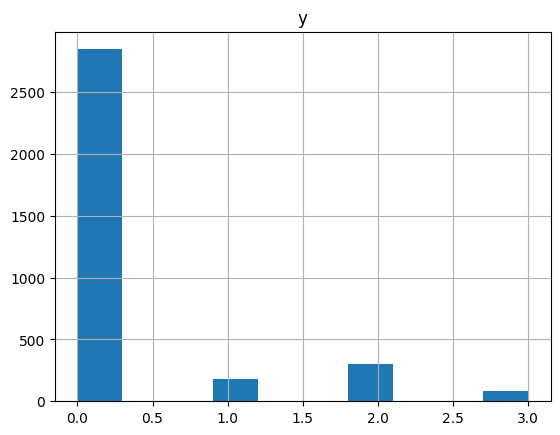

In [76]:
y_pred.hist()